In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from fbprophet import Prophet

In [8]:
df = pd.read_csv('/content/drive/MyDrive/zillow_data.csv')
ny = df[df['City'] == 'New York']
ny = ny[ny['CountyName'] == 'New York']
ny.dropna(inplace=True)
la = df[df['City'] == 'Los Angeles']
la.dropna(inplace=True)
chicago = df[df['City'] == 'Chicago']
chicago.dropna(inplace=True)
chicago1 = chicago.sort_values(by='SizeRank', ascending=True)[:2]
la1 = la.sort_values(by='SizeRank', ascending=True)[:2]
df1 = pd.concat([chicago1, la1, ny])
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)
df1.set_index('RegionName', inplace=True)
drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
dates = df1.drop(drop, axis=1)

In [9]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    return pd.to_datetime(df.columns.values, format='%Y-%m')

In [10]:
columns_new = get_datetimes(dates)
dates.columns = columns_new
dates.rename_axis(None, inplace=True)
transposed = dates.T
transposed.rename_axis('Dates', inplace=True)
transposed.head()

,60657,60614,90046,90034,10128,11106
Dates,,,,,,
1996-04-01,334200.0,498100.0,340600.0,231300.0,3676700.0,164600.0
1996-05-01,335400.0,500900.0,341700.0,231700.0,3704200.0,165300.0
1996-06-01,336500.0,503100.0,343000.0,232100.0,3729600.0,165900.0
1996-07-01,337600.0,504600.0,344400.0,232400.0,3754600.0,166700.0
1996-08-01,338500.0,505500.0,346100.0,232700.0,3781800.0,167400.0


In [39]:
chi1_norm = pd.DataFrame(transposed[60657])
chi2_norm = pd.DataFrame(transposed[60614])
la1_norm = pd.DataFrame(transposed[90046])
la2_norm = pd.DataFrame(transposed[90034])
ny1_norm = pd.DataFrame(transposed[10128])
ny2_norm = pd.DataFrame(transposed[11106])

FB Prophet only takes 2 column data labeled 'ds' and 'y'

In [41]:
def eda(data):
  data['ds'] = data.index
  data['y'] = data[data.columns[0]]
  data.reset_index(inplace=True)
  data.drop(data.columns[1], axis=1, inplace=True)
  data.drop(data.columns[0], axis=1, inplace=True)

  return data

In [42]:
chi1 = eda(chi1_norm)
chi2 = eda(chi2_norm)
la1 = eda(la1_norm)
la2 = eda(la2_norm)
ny1 = eda(ny1_norm)
ny2 = eda(ny2_norm)

In [46]:
zips = [chi1, chi2, la1, la2, ny1, ny2]

In [75]:
def prophet(data, years):
    train, test = data.iloc[:199], data.iloc[199:]
    
    #first model is used to calculate train/test RMSE
    model = Prophet(interval_width=.95)
    model.fit(train)
    
    future_dates = model.make_future_dataframe(periods=66, freq='MS')
    train_forecast = model.predict(pd.DataFrame(train['ds']))
    test_forecast = model.predict(future_dates)[199:]
    
    trainpreds = train_forecast['yhat']
    testpreds = test_forecast['yhat']
    
    #model2 is fitted to all the data and used to predict future prices
    model2 = Prophet(interval_width=.95)
    model2.fit(data)

    future_dates2 = model2.make_future_dataframe(periods=12*years, freq='MS')
    test_forecast2 = model2.predict(future_dates2)[265:]
    testpreds2 = test_forecast2['yhat']
    original_price = data['y'][264]
    final_price = testpreds2[264+12*years]
    roi = ((final_price - original_price)/original_price)*100

    plt.plot(data['y'], label='Actual')
    plt.plot(testpreds2, label='Prediction')
    plt.legend()
    plt.show()
    
    print('Train RMSE: ', mean_squared_error(train['y'], trainpreds)**0.5)
    print('Test RMSE: ', mean_squared_error(test['y'], testpreds)**0.5)
    print('Price Today: ${}'.format(original_price))
    print('Price in {} years: ${}'.format(years, final_price))
    print('ROI: {}%'.format(roi))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


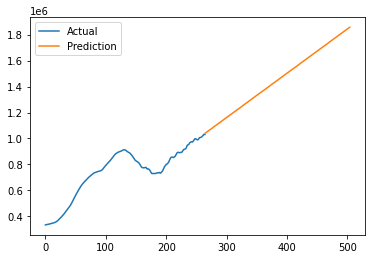

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train RMSE:  9235.760096281256
Test RMSE:  251283.0356793832
Price Today: $1030600.0
Price in 20 years: $1856913.8676463163
ROI: 80.17794174716828%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


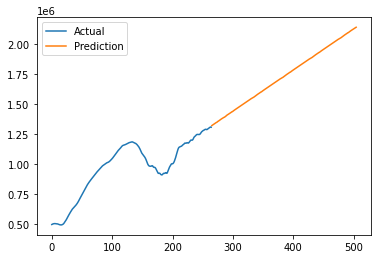

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train RMSE:  15466.284357510704
Test RMSE:  367816.3813903493
Price Today: $1307000.0
Price in 20 years: $2137908.8887536773
ROI: 63.57374818314286%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


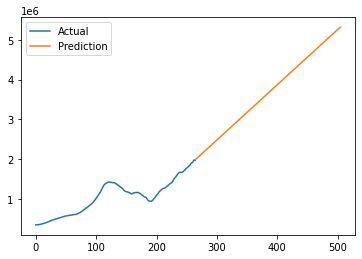

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train RMSE:  22867.472984798715
Test RMSE:  837824.2005666224
Price Today: $1966900.0
Price in 20 years: $5317138.608087969
ROI: 170.3309069138222%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


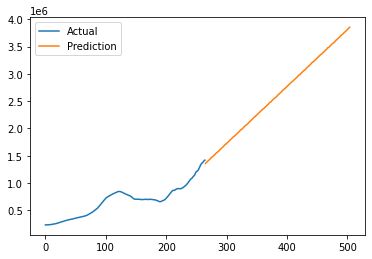

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train RMSE:  5589.19941814642
Test RMSE:  420603.1579835149
Price Today: $1419100.0
Price in 20 years: $3853978.9089764366
ROI: 171.57909301504029%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


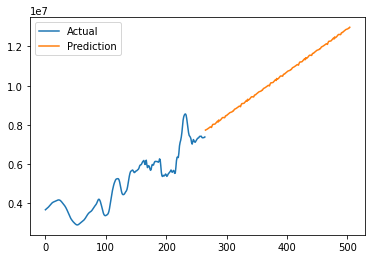

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Train RMSE:  332096.04873819015
Test RMSE:  1025583.363922284
Price Today: $7386600.0
Price in 20 years: $12981069.972638084
ROI: 75.73809293366479%


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


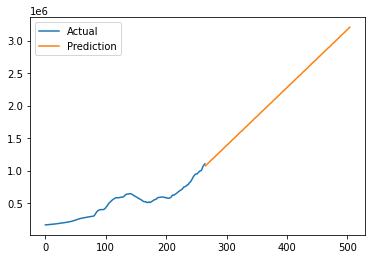

Train RMSE:  15832.489620661316
Test RMSE:  239947.33736432958
Price Today: $1104300.0
Price in 20 years: $3205375.4459766615
ROI: 190.26310295903843%


In [77]:
for x in zips:
    prophet(x, 20)